In [1]:
#!pip install langdetect
#!pip install scattertext
#!pip install spacy
#!pip install gensim
#!pip install pyLDAvis

In [1]:
import pandas as pd
import numpy as np 
import pickle
import matplotlib.pyplot as plt
import os 
import re
from langdetect import detect
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
import seaborn as sns
import spacy
import scattertext as st
import nltk
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim

In [20]:
sw = stopwords.words("english")

## Load Data

In [2]:
df = pd.read_excel('./data/fake_job_postings.xlsx')

## Cleaning 
- Replace null to string "missing" -- instead of dropping missings, use as a valid observation. Could be that fake posts often have missing fields
- Separate country, state, city from location
- Drop non-english text entries
- Clean text columns: separate sentences, remove URLs, non-ascii, punctuation, extra spaces and white space
- Redefine education bins
- Drop salary range: very often missing, unsure what units are used in foreign countries, inconsistent time frame (hourly, monthly, yearly)

In [3]:
# replace null to "missing"
for c in df.columns:
    df[c] = np.where(df[c].isnull(), 'missing', df[c])

In [4]:
# separate location attributes
df['country'] = df.location.str.split(',').str[0]
df['state'] = df.location.str.split(', ').str[1]
df['city'] = df.location.str.split(', ').str[2]

In [5]:
# drop non-english postings
df['language'] = df['description'].apply(lambda x: detect(x))
df = df[df.language == 'en']

In [6]:
# spot cleanup for nyc abbreviations
df.city = np.where(df.city == 'nyc', 'new york city', df.city)
df.city = np.where(df.city == 'ny', 'new york city', df.city)
df.city = np.where(df.city == 'new york', 'new york city', df.city)

In [7]:
# text cleaning 
text_columns = ['country', 'state', 'city', 'title', 'department', 'company_profile', 'description', 'requirements',
               'benefits', 'required_experience', 'employment_type', 'required_education', 'industry', 'function']
for c in text_columns:
    df[c] = df[c].apply(lambda x: re.sub(r'â€™', '', str(x))) # remove specific character used for apostrophe
                                                              # replace with '' before ascii removal so contractions together
    df[c] = df[c].str.replace('([A-Z])((?=[a-z]))', r' \1') # if lower case followed by upper case, separate by space
                                                            # works for a.A as well 
    df[c] = df[c].str.lower() # downcase 
    df[c] = np.where(df[c] == '', 'missing', df[c]) # empty strings mark as missing
    df[c] = df[c].apply(lambda x: ''.join([" " if ord(i) < 32 or ord(i) > 126 else i for i in str(x)])) # remove non-ascii
    df[c] = df[c].apply(lambda x: re.sub('http[^\s]+ ', ' ', str(x))) # remove URLs
    df[c] = df[c].apply(lambda x: re.sub('url[^\s]+ ', ' ', str(x))) # remove URLs
    df[c] = df[c].apply(lambda x: re.sub(r'[^\w\s]','', x)) # remove punctuation. Replace with '' so don't separate contractions
    df[c] = df[c].apply(lambda x: re.sub(' +', ' ', x)) # remove double and triple spaces
    df[c] = df[c].apply(lambda x: str(x).strip()) # remove white space trailing/leading

In [8]:
# redefine education bins
df['education_bin'] = np.where(df.required_education.isin(['some high school coursework']),
                               'less than high school', df.required_education)
df.education_bin = np.where(df.required_education.isin(['high school or equivalent']), 'high school', df.education_bin)
df.education_bin = np.where(df.required_education.isin(['vocational hs diploma', 'vocational degree',
                                                       'vocational']), 'vocational', df.education_bin)
df.education_bin = np.where(df.required_education.isin(['some college coursework completed']), 'some college', df.education_bin)
df.education_bin = np.where(df.required_education.isin(['unspecified']), "missing", df.education_bin)

In [9]:
# drop salary range variable 
del df['salary_range']

## EDA

In [10]:
df.fraudulent = pd.to_numeric(df.fraudulent)

__Bar Plots of Metadata Frequency in Fraudulent Posts__

In [12]:
def bar_plt(col, titlecol, boolean = False):
    
    # count number of fraudulent postings and total postings -> calculate fraction of postings that are fraud
    fraudcnt = df.groupby(col).fraudulent.sum().to_frame()
    totcnt = df.groupby(col).job_id.count().to_frame()
    frac = pd.merge(fraudcnt, totcnt, left_index = True, right_index = True)
    frac['frac'] = frac.fraudulent / frac.job_id 
    
    # exclude if fewer than 10 total postings (else fraction may be close to 100%)
    frac = frac[frac.job_id > 10]
    
    # sort and take top 10 
    frac['index_col'] = frac.index
    frac = frac.reset_index(drop = True)
    if boolean == False:
        frac = frac.sort_values('frac').tail(10)

    # plot
    cnt = len(frac)
    sns.barplot(x='index_col', y="frac", data=frac, order=frac['index_col'])
    if boolean == False:
        plt.xticks(rotation=90)
    else:
        plt.xticks([0, 1], ['No', 'Yes'])
        
    if cnt == 10:
        plt.title('Top 10 ' + titlecol + ' by Percent Fraudulent Postings')
    else:
        plt.title(titlecol + ' by Percent Fraudulent Postings')
        
    plt.ylabel('Fraction of Fraudulent Postings')
    plt.xlabel('')

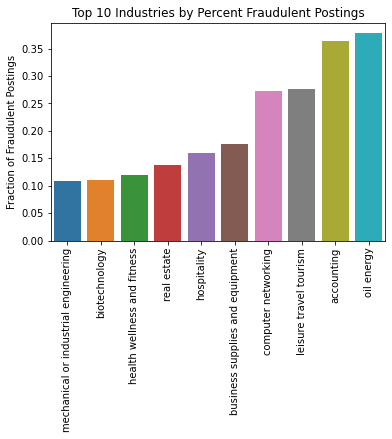

In [13]:
bar_plt('industry', 'Industries')

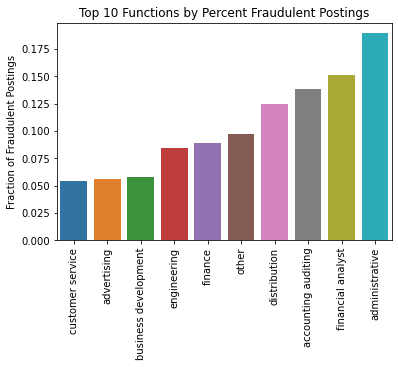

In [14]:
bar_plt('function', 'Functions')

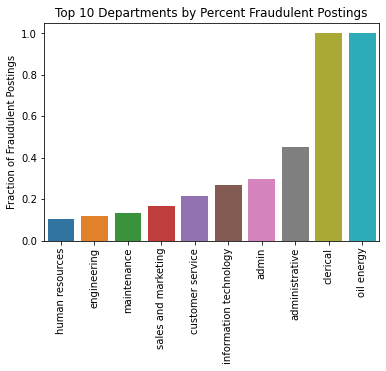

In [15]:
bar_plt('department', 'Departments')
# clerical and oil energy appear to be the same handful of job postings posted many times with different locations or titles

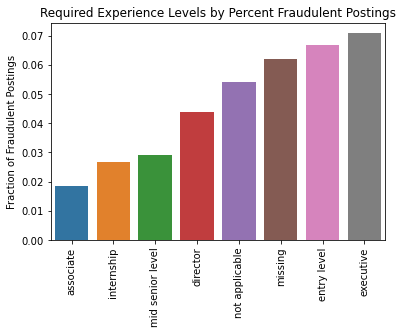

In [16]:
bar_plt('required_experience', 'Required Experience Levels')

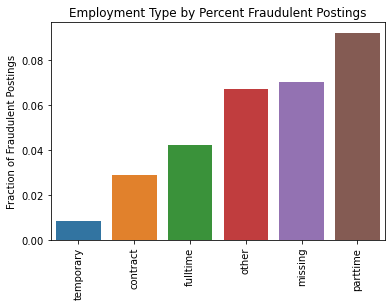

In [17]:
bar_plt('employment_type', 'Employment Type')

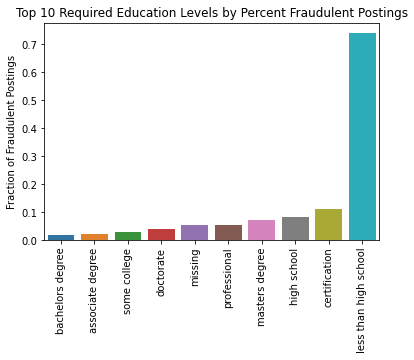

In [18]:
bar_plt('education_bin', 'Required Education Levels')

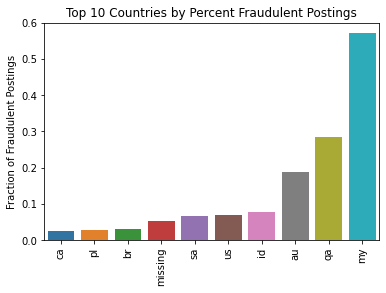

In [19]:
bar_plt('country', 'Countries')

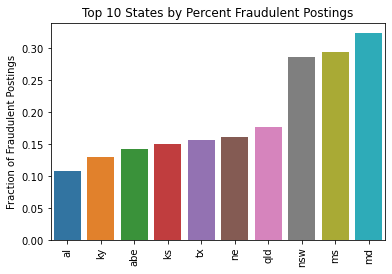

In [20]:
bar_plt('state', 'States')

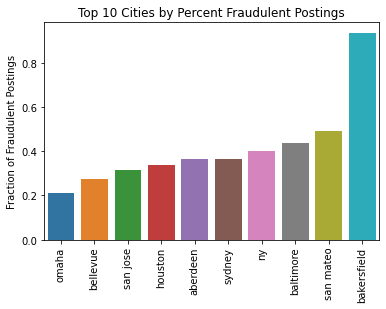

In [21]:
bar_plt('city', 'Cities')

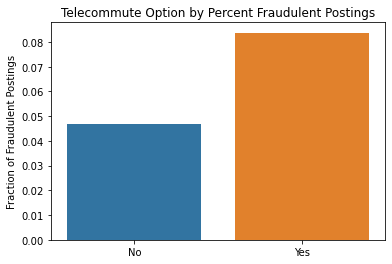

In [22]:
bar_plt('telecommuting', 'Telecommute Option', boolean = True)

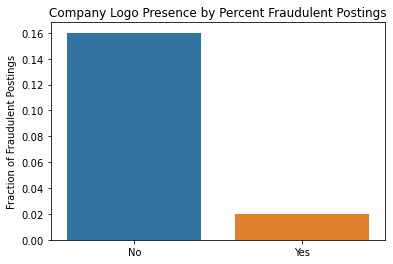

In [23]:
bar_plt('has_company_logo', 'Company Logo Presence', boolean = True)

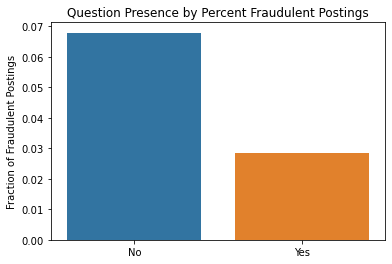

In [24]:
bar_plt('has_questions', 'Question Presence', boolean = True)

__Visualize Common Words in Fake vs Real Postings using Scattertext__   
Tokenize and remove stop words. Don't bother with lemmatization for exploratory analysis + interferes with ability to see examples using scattertext interactive html

In [56]:
nlp = spacy.load('en')

In [25]:
# run in terminal (with admina priviledges): 'py -m spacy download en'
#nltk.download('stopwords')

In [11]:
df['fraudulent_words'] = np.where(df.fraudulent == 1, 'fake', 'real')

In [27]:
def scattertext_visualize(col):
    
    df['parse'] = df[col].apply(st.whitespace_nlp_with_sentences)
    
    corpus = st.CorpusFromParsedDocuments(
        df, category_col='fraudulent_words', parsed_col='parse'
    ).build().get_unigram_corpus().compact(st.AssociationCompactor(2000)).remove_terms(sw, ignore_absences=True)

    html = st.produce_scattertext_explorer(
        corpus,
        category='fake', category_name='Fraudulent', not_category_name='Real',
        minimum_term_frequency=0, pmi_threshold_coefficient=0,
        width_in_pixels=1000,
        transform=st.Scalers.dense_rank,
        metadata=corpus.get_df()['title']
    )
    open('./scattertext_' + col + '.html', 'w').write(html)

In [28]:
nlp_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']
for c in nlp_columns:
    scattertext_visualize(c)

## Topic Modeling
Sections of code adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling

- Combine text fields into single string
- Tokenize, remove stop words, lemmatize based on POS 
- Build term frequency corpus
- Build LDA Model

In [76]:
# combine text fields into single string 
for c in ['title', 'company_profile', 'description', 'requirements', 'benefits']:
    df[c] = np.where(df[c] == 'missing', '', df[c])
    
df['text'] = df.title + ' ' + df.company_profile + ' ' + df.description + ' ' + df.requirements + ' ' + df.benefits

In [77]:
# function from
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [79]:
# tokenize
df.text = df.text.apply(lambda row: row.split(' '))
# remove stop words
df.text = df.text.apply(lambda row: [w for w in row if w not in sw])

# convert into list 
text = df.text.values.tolist()

# lemmatize and remove proper nouns 
# ex removing company names. Not important for topic modeling. 
text = lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [81]:
# save text string (10 minutes to run tokenization through lemmatization process)
with open('textlst.pkl', 'wb') as f:
    pickle.dump(text, f)

In [61]:
#with open('textlst.pkl', 'rb') as f:
#    lst = pickle.load(f)

In [89]:
# term document frequency corpus for LDA
corpus_dict = corpora.Dictionary(text)
corpus = [corpus_dict.doc2bow(t) for t in text]

In [103]:
#[[(corpus_dict[id], freq) for id, freq in cp] for cp in corpus[:2]]  - human readable format

In [95]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=corpus_dict,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [102]:
# visualize topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, corpus_dict)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13    -0.152584 -0.026977       1        1  18.090061
17    -0.075500 -0.237598       2        1  13.279626
16    -0.171470 -0.005050       3        1   8.894625
11    -0.127355  0.153104       4        1   8.705943
9      0.001206 -0.131575       5        1   6.305676
3     -0.012500  0.062530       6        1   5.840804
2     -0.074742  0.162868       7        1   5.638958
5     -0.158549 -0.065985       8        1   5.276093
6     -0.117049  0.003345       9        1   4.785123
15    -0.023825  0.167939      10        1   3.777766
4     -0.009642  0.143994      11        1   3.290085
14     0.039218  0.185512      12        1   3.237584
19     0.043909 -0.127939      13        1   2.460113
12    -0.013265  0.041369      14        1   2.191770
0      0.220761  0.109245      15        1   1.969092
8      0.120383 -0.105505      16        1   1.755361
1      0.049973 -0.112142      17        1   1.505410
7     -0.013144 -0.131506      18        1   1.247243
18     0.368282  0.020689      19        1   0.962984
10     0.105893 -0.106319      20        1   0.785680, topic_info=            Term          Freq         Total Category  logprob  loglift
193     customer  36574.000000  36574.000000  Default  30.0000  30.0000
287      product  20666.000000  20666.000000  Default  29.0000  29.0000
614         sale  18702.000000  18702.000000  Default  28.0000  28.0000
317      service  34280.000000  34280.000000  Default  27.0000  27.0000
714          job  16185.000000  16185.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
67          help    313.999298  12571.643555  Topic20  -4.5568   1.1566
226       growth    241.226303   5699.271484  Topic20  -4.8205   1.6840
334         take    237.068024   8472.480469  Topic20  -4.8379   1.2701
206  environment    254.778198  16821.816406  Topic20  -4.7658   0.6563
389       ensure    220.902374  11484.670898  Topic20  -4.9085   0.8953

[1340 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
151       1  0.154799  ability
151       2  0.001741  ability
151       3  0.122668  ability
151       4  0.145988  ability
151       6  0.088057  ability
...     ...       ...      ...
658      12  0.022932     year
658      14  0.009088     year
658      15  0.046758     year
658      16  0.049348     year
658      17  0.003014     year

[3511 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 18, 17, 12, 10, 4, 3, 6, 7, 16, 5, 15, 20, 13, 1, 9, 2, 8, 19, 11])

In [128]:
# reconstruct dataframe with metadata columns with topic probabilities 
topicdf = pd.DataFrame()
for i in range(1, 21):
    topicdf['topic' + str(i)] = 0
    
for i, row in enumerate(lda_model[corpus]):
    s = pd.Series(dtype = float)
    
    for j in row[0]:
        s['topic' + str(j[0])] = j[1] 
    topicdf = topicdf.append(s, ignore_index = True)

In [ ]:
# how to tune number of topics?
    # use as parameter in classification performance?
    # topic coherence as evaluation metric
        # https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0